# Remote Robot Edition
In this exercise we are going to go through the basics of remote controlling a liquid handler robot - OpenTrons OT-2

Useful Links:
- [API Documentation](https://docs.opentrons.com/v2/index.html)
- [Protocol Library](https://protocols.opentrons.com/)

Log: 
- 20220112
- use the api to do PCR, purification
- 20220815
- modify the excel reading, change the  barcode24_combination reading methods
- 20220816
- another run:46-61

In [1]:
# First, we load the OpenTrons library and call home
# Re-run this cell will reset the protocol!
from opentrons import protocol_api

metadata = {
    'protocolName': 'My Protocol',
    'author': 'Weiting <weitinglin66@gmail.com>',
    'description':'Simple protocol to get started using OT2',
    'apiLevl': '2.5'
}
        

In [2]:
import opentrons.execute
protocol = opentrons.execute.get_protocol_api('2.5')

Failed to initialize character device, will not be able to control gpios (lights, button, smoothiekill, smoothie reset). Only one connection can be made to the gpios at a time. If you need to control gpios, first stop the robot server with systemctl stop opentrons-robot-server. Until you restart the server with systemctl start opentrons-robot-server, you will be unable to control the robot using the Opentrons app.


# 本次實驗規劃
## 時間紀錄：20220816
## 重新實作的檢體標號：46-61
## 相關檔案連結:

# Load labware and pipete
Labware are the physical components mounted on the OpenTrons deck. Labware can include tips, wells, racks, etc.
We can see which labware is already part of the OpenTrons Labware Library.

p300:20 ul - 300 ul
p20: 1 - 20 uL

the labware we had:
## Reservour
1. NEST 96 Well Plate 100 uL: nest_96_wellplate_100ul_pcr_ful_skirt
2. Opentrons 24 Tube Rack with NEST 1.5 ml Snapcap: opentrons_24_tuberack_nest_1.5ml_snapcap
## Tips
3. Opentrons 96 Tips Rack 300 ul: opentrons_96_tiprack_300ul
4. Opentrons 96 Tips Rack 10 ul: opentrons_96_10ul




In [3]:
# Define the labware

# ==== Tips
tips_300 = protocol.load_labware('opentrons_96_tiprack_300ul',
                                 '1',
                                 'Opentrons Tips')
    


tips_20 = protocol.load_labware('opentrons_96_tiprack_20ul',
                                '4',
                                'Opentrons Tips')

# ==== Reservoir

LInput_container = protocol.load_labware('opentrons_24_tuberack_nest_1.5ml_snapcap',
                                     '5',
                                     'Product source')

Input_container = protocol.load_labware('nest_96_wellplate_100ul_pcr_full_skirt',
                                         '8',
                                        'Primer and DNA Source')

Output_container = protocol.load_labware('nest_96_wellplate_100ul_pcr_full_skirt',
                                         '9',
                                         'Mixture Endproduct')


# ==== Pipette


left_pipette = protocol.load_instrument('p300_single',
                                              'left',
                                              tip_racks=[tips_300])

right_pipette = protocol.load_instrument('p20_single_gen2',
                                              'right',
                                              tip_racks=[tips_20])

# Adjust the Position for accuracy fluid handling
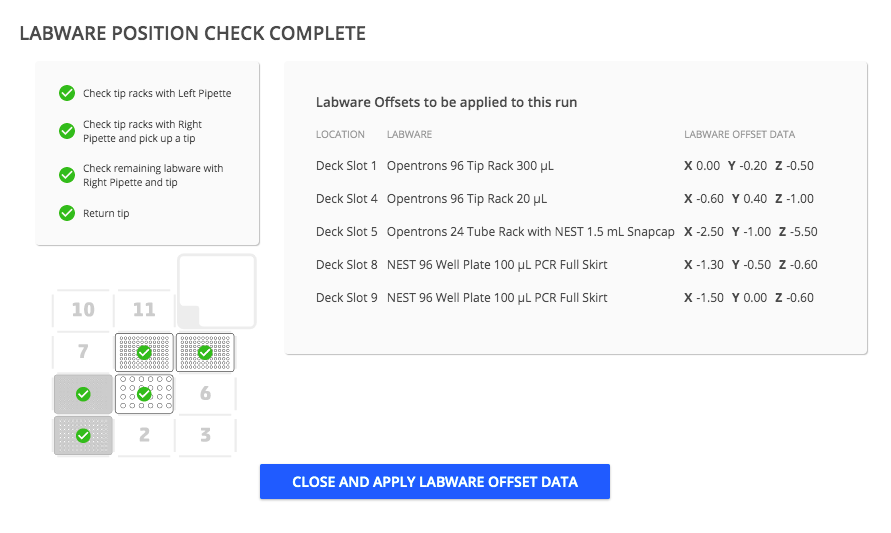

In [4]:
# Position Calibration with the data gathered from GUI workflow information
# Perfect!! we can use the GUI workflow for calibration, then take the parameter in the jupyter
# Tips
tips_300.set_offset(0,-0.2,-0.5) # Slot 1

tips_20.set_offset(-0.6,0.4,-1)  # Slot 4
# Reservoir
LInput_container.set_offset(-2.5, -1, -5.5)      # Slot 5

Input_container.set_offset(-1.3, -0.5, -0.6)       # Slot 8

Output_container.set_offset(-1.5, 0, -0.6)      # Slot 9    

In [5]:
protocol.home()

Out of bounds move: X=(418.00000000000006 motor controller, 416.5353919287881 deck) too high for limit 418.0
Out of bounds move: X=(418.00000000000006 motor controller, 416.5353919287881 deck) too high for limit 418.0


# Setup and Test Module SetOff

In [39]:
left_pipette.drop_tip()

<InstrumentContext: p300_single_v2.1 in LEFT>

In [40]:
left_pipette.flow_rate.aspirate = 20
left_pipette.flow_rate.dispense = 30

left_pipette.pick_up_tip(tips_300[next(iter_tips)])
left_pipette.well_bottom_clearance.dispense = 1 # 這高度就算可以惹
left_pipette.aspirate(30, LInput_container['C1'])
left_pipette.dispense(30, LInput_container['C1'])
left_pipette.blow_out()  
left_pipette.drop_tip() 

<InstrumentContext: p300_single_v2.1 in LEFT>

In [112]:
right_pipette.well_bottom_clearance.dispense = 1  # 這高度就算可以惹
right_pipette.dispense(1.5, Output_container['C6'])
right_pipette.well_bottom_clearance.dispense = 2
right_pipette.well_bottom_clearance.aspirate = 2
right_pipette.flow_rate.aspirate = 1.5
right_pipette.flow_rate.dispense = 3
right_pipette.aspirate(1.5, Output_container['C6'])
right_pipette.dispense(1.5, Output_container['C6'])
right_pipette.aspirate(1.5, Output_container['C6'])
right_pipette.dispense(1.5, Output_container['C6'])
right_pipette.aspirate(1.5, Output_container['C6'])
right_pipette.dispense(1.5, Output_container['C6'])

right_pipette.blow_out()  

<InstrumentContext: p20_single_v2.1 in RIGHT>

# Input the Layout information CSV
- single primers mixed as barcode paired to 16 tubes
- log: 
- 20220610: add 13 arc-aro, 14 aro-glp, 15 pta-tpi
- 20220622: use 16 to 24 combination
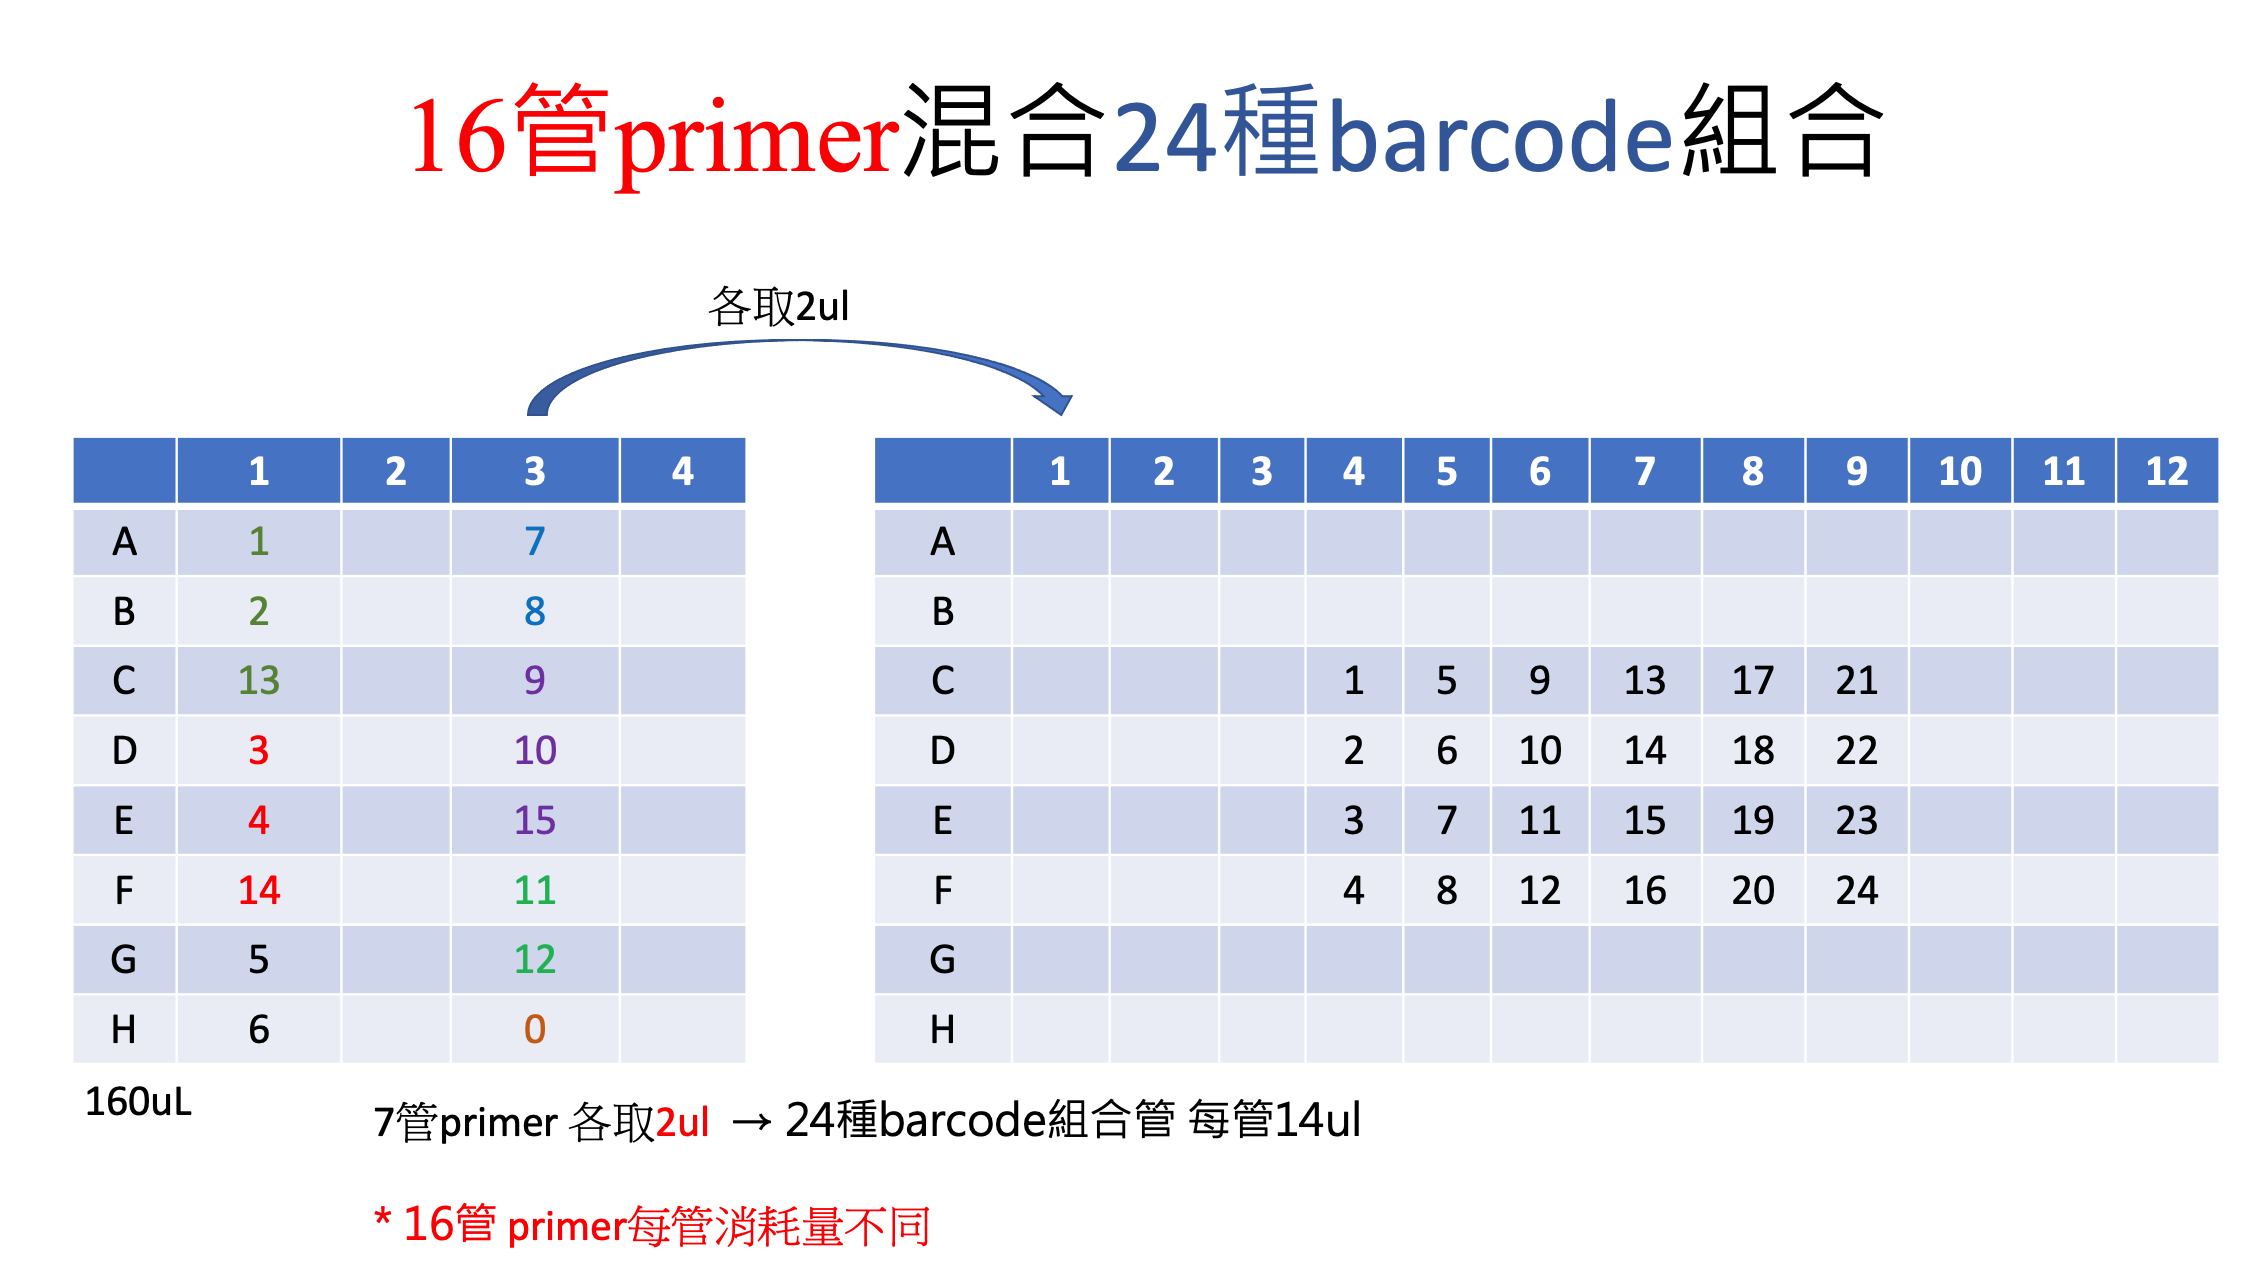


In [22]:
# primer location in 96-well: mapping primer to its physical well position
#Opentron 操作細節
#https://support.opentrons.com/s/article/Connecting-to-your-OT-2-with-SSH
#https://support.opentrons.com/s/article/Setting-up-SSH-access-to-your-OT-2
# use the code to import plate mapping information into the python3
# scp -i /Users/Weitinglin/Documents/Repository/opentron_202206/ot2_ssh_key  20220815_16tube_position.csv root@169.254.199.65:/root/script
# scp -i /Users/Weitinglin/Documents/Repository/opentron_202206/ot2_ssh_key  20220815_16_endproductLayout_set.csv root@169.254.199.65:/root/script
# scp -i /Users/Weitinglin/Documents/Repository/opentron_202206/ot2_ssh_key  20220815_barcode108_combination.csv root@169.254.199.65:/root/script
# scp -i /Users/Weitinglin/Documents/Repository/opentron_202206/ot2_ssh_key  20220815_DNAtoPosition.csv root@169.254.199.65:/root/script

import csv
import string

inputPlate_position = {}
with open('/root/script/20220815_16tube_position.csv', newline='') as f:
    reader = csv.reader(f)
    i=1
    for row in reader:
        j=0
        for endproduct in row:
            if endproduct != '':    
                position = f"{string.ascii_uppercase[j]}{i}"
                tmp ={endproduct:position}
                inputPlate_position.update(tmp)
                #print(tmp)
            j=j+1
        i=i+1

output_24_combination_layout={}        
with open('/root/script/20220816_16_endproductLayout_set.csv', newline='') as f:
    reader = csv.reader(f)
    i=1
    for row in reader:
        j=0
        for endproduct in row:
            if endproduct != '':    
                position = f"{string.ascii_uppercase[j]}{i}"
                tmp ={endproduct:position}
                output_24_combination_layout.update(tmp)
                #print(tmp)
            j=j+1
        i=i+1

barcode24_combination = {}
with open('/root/script/20220816_barcode108_combination.csv', newline='') as f:
    reader = csv.reader(f)
    items=list(output_24_combination_layout.keys())
    i=0
    for row in reader:
        j=0
        key=items[i]
        combination = []
        for barcode in row:
            combination.append(barcode)
        tmp ={key:combination}
        barcode24_combination.update(tmp)
        i=i+1
        
        
DNAtobarcode = {}

with open('/root/script/20220816_DNAtoPosition.csv', newline='') as f:
    reader = csv.reader(f)
    items=list(output_24_combination_layout.keys())
    i=0
    for row in reader:
        for item in row:
            tmp ={items[i]:item}
            DNAtobarcode.update(tmp)
        i=i+1


In [23]:
DNAtobarcode

{'46': 'ST15',
 '47': 'ST1232',
 '48': 'ST97',
 '49': 'ST1',
 '50': 'ST789',
 '51': 'ST239',
 '52': 'ST7',
 '53': 'ST59',
 '54': 'ST15',
 '55': 'ST1232',
 '56': 'ST97',
 '57': 'ST1',
 '58': 'ST789',
 '59': 'ST239',
 '60': 'ST7',
 '61': 'ST59'}

In [9]:
tip_num = []
for num in list(range(1,13)):
    for pos in list(range(1,9)):
        tmp_pos = f"{string.ascii_uppercase[pos-1]}{num}"
        tip_num.append(tmp_pos)
        
iter_tips = iter(tip_num)

In [10]:
list(output_24_combination_layout.keys())

['46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61']

# Overall Workflow Design
- step 1 : put the large volume to each 24 position(A1 -> 36.5 uL): use 300ul tips
- step 2 : put primer into the each 24 position (input 96-> 24, each 2 ul)
- step 3 : put DNA into each 24 position (input 1.5 each)


# Step 1
## move  mixture to each 24 position (each 36.5 ul)

In [13]:
####### Opentrion description##############
#
# make 24 tubes with mixture 
#
###########################################
####### Set up machine pipette parameter
left_pipette.flow_rate.aspirate = 20  # speed too quick
left_pipette.flow_rate.dispense = 30
left_pipette.well_bottom_clearance.dispense = 1 # 這高度就算可以惹 

target_number = list(output_24_combination_layout.keys())
iter_target = iter(target_number)

# pick tips once

        
# tips change module
for time in list(range(1,3)):
    left_pipette.pick_up_tip(tips_300[next(iter_tips)])
    left_pipette.aspirate(300, LInput_container['A1'])
    
    for number in list(range(1, 9)):

        iter_number = next(iter_target)
        disperse_position = output_24_combination_layout[f"{iter_number}"]
        left_pipette.well_bottom_clearance.dispense = 1
        left_pipette.dispense(36.5, Output_container[disperse_position])
        
    left_pipette.drop_tip()
        
 

Out of bounds move: X=(418.00000000000006 motor controller, 416.5353919287881 deck) too high for limit 418.0


# Step 2
## put primer according to barcode design into 24 position (each 2 ul)

In [14]:
tip_num = []
for num in list(range(1,13)):
    for pos in list(range(1,9)):
        tmp_pos = f"{string.ascii_uppercase[pos-1]}{num}"
        tip_num.append(tmp_pos)
        
iter_tips = iter(tip_num)

In [15]:
output_24_combination_layout

{'46': 'C3',
 '47': 'D3',
 '48': 'E3',
 '49': 'F3',
 '50': 'C4',
 '51': 'D4',
 '52': 'E4',
 '53': 'F4',
 '54': 'C5',
 '55': 'D5',
 '56': 'E5',
 '57': 'F5',
 '58': 'C6',
 '59': 'D6',
 '60': 'E6',
 '61': 'F6'}

In [16]:
####### Opentrion description ===
#  put the primer according to barcode deisng, seperate into two steps due to tips
#
#  Position ONE
###########################################
####### Set up machine pipette parameter
import time
import sys
# 150 sec for 1 set
print("=== Begine the Barcode Mixing Protocol ===")
print("Start : %s" % time.ctime())

right_pipette.flow_rate.aspirate = 1.5  # 
right_pipette.flow_rate.dispense = 1.5
right_pipette.well_bottom_clearance.dispense = 1 # 這高度就算可以惹 

target_number = list(output_24_combination_layout.keys())
iter_target = iter(target_number)

# Dedault Aspirate 1mm above the bottom of the well
# Aspirate 1mm above the bottom of the well

for item_set in target_number:
    print("set item: ",item_set,"test")
    print(barcode24_combination[item_set])
    iter_number = next(iter_target)
    for primer in barcode24_combination[item_set]:
        primer_locate = inputPlate_position[primer]
        destination = output_24_combination_layout[f"{iter_number}"]
        print(primer_locate)
        print(destination)
        right_pipette.pick_up_tip(tips_20[next(iter_tips)])
        right_pipette.aspirate(2, Input_container[primer_locate])
        right_pipette.dispense(2, Output_container[destination])
        right_pipette.blow_out()    
        right_pipette.drop_tip()
        
print("End : %s" % time.ctime())

=== Begine the Barcode Mixing Protocol ===
Start : Tue Aug 16 02:42:38 2022
set item:  46 test
['13', '14', '6', '8', '9', '11']
C1
C3
F1
C3
H1
C3
B3
C3
C3
C3
F3
C3
set item:  47 test
['13', '3', '5', '7', '10', '11']
C1
D3
D1
D3
G1
D3
A3
D3
D3
D3
F3
D3
set item:  48 test
['13', '4', '5', '7', '10', '11']
C1
E3
E1
E3
G1
E3
A3
E3
D3
E3
F3
E3
set item:  49 test
['13', '14', '5', '7', '10', '11']
C1
F3
F1
F3
G1
F3
A3
F3
D3
F3
F3
F3
set item:  50 test
['1', '3', '6', '8', '10', '11']
A1
C4
D1
C4
H1
C4
B3
C4
D3
C4
F3
C4
set item:  51 test
['2', '3', '6', '8', '10', '11']
B1
D4
D1
D4
H1
D4
B3
D4
D3
D4
F3
D4
set item:  52 test
['13', '3', '6', '8', '10', '11']
C1
E4
D1
E4
H1
E4
B3
E4
D3
E4
F3
E4
set item:  53 test
['1', '4', '6', '8', '10', '11']
A1
F4
E1
F4
H1
F4
E1
C5
H1
C5
B3
C5
D3
C5
F3
C5
set item:  55 test
['13', '4', '6', '8', '10', '11']
C1
D5
E1
D5
H1
D5
B3
D5
D3
D5
F3
D5
set item:  56 test
['1', '14', '6', '8', '10', '11']
A1
E5
F1
E5
H1
E5
B3
E5
D3
E5
F3
E5
set item:  57 test
['2',

# Step 3
## put DNA into the 24 mixture and mix (echo 1.5 ul)

In [26]:
tip_num = []
for num in list(range(1,13)):
    for pos in list(range(1,9)):
        tmp_pos = f"{string.ascii_uppercase[pos-1]}{num}"
        tip_num.append(tmp_pos)
        
iter_tips = iter(tip_num)

In [25]:
output_24_combination_layout.keys()

dict_keys(['46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61'])

In [27]:
####### Opentrion description ===
#  
#  put the DNA to each position
#  
###########################################
####### Set up machine pipette parameter
#right_pipette.flow_rate.aspirate = 1.5  # speed too quick
#right_pipette.flow_rate.dispense = 1.5
#right_pipette.well_bottom_clearance.dispense = 1 # 這高度就算可以惹 

import time
import sys

print("=== Begine the Add DNA to mixture ===")
print("Start : %s" % time.ctime())

# Dedault Aspirate 1mm above the bottom of the well
# Aspirate 1mm above the bottom of the well


for item_set in list(output_24_combination_layout.keys()):
    print("set item: ",item_set,"test")
    print(DNAtobarcode[item_set])
    DNAst=DNAtobarcode[item_set]
    DNA_locate = inputPlate_position[DNAst]
    destination = output_24_combination_layout[f"{item_set}"]
    print(DNA_locate)
    print(destination)    
    right_pipette.pick_up_tip(tips_20[next(iter_tips)])
    right_pipette.well_bottom_clearance.dispense = 1
    right_pipette.well_bottom_clearance.aspirate = 1
    right_pipette.aspirate(1.5, Input_container[DNA_locate])
    right_pipette.dispense(1.5, Output_container[destination])
    right_pipette.blow_out()    
    right_pipette.drop_tip()
    
    # 3 test: C7-> E4 weird
    # 4 test: C7-> E4 weird
print("End : %s" % time.ctime())

=== Begine the Add DNA to mixture ===
Start : Tue Aug 16 03:31:45 2022
set item:  46 test
ST15
D8
C3
set item:  47 test
ST1232
E7
D3
set item:  48 test
ST97
F8
E3
set item:  49 test
ST1
G7
F3
set item:  50 test
ST789
H8
C4
set item:  51 test
ST239
A7
D4
set item:  52 test
ST7
B8
E4
set item:  53 test
ST59
C7
F4
set item:  54 test
ST15
D8
C5
set item:  55 test
ST1232
E7
D5
set item:  56 test
ST97
F8
E5
set item:  57 test
ST1
G7
F5
set item:  58 test
ST789
H8
C6
set item:  59 test
ST239
A7
D6
set item:  60 test
ST7
B8
E6
set item:  61 test
ST59
C7
F6
End : Tue Aug 16 03:38:19 2022


# Thermocycler PCR reagent
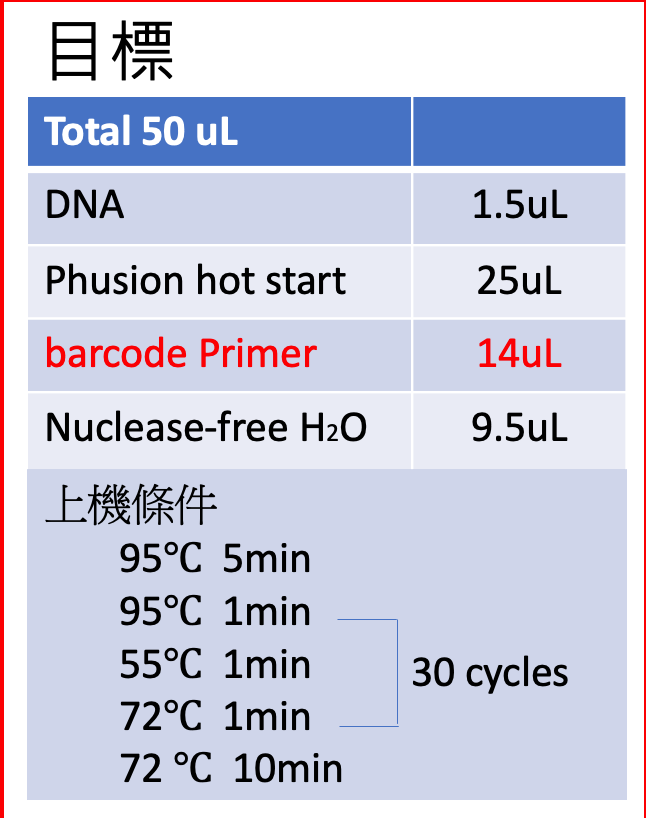